# MNIST handwritten digits recognition using Probabilistic Models

** Last update: Febuary 15th 2018 at 10:35pm **

** By Shuning Zhao **

## General Instructions
This code aims to build a class-conditional classifer using Gaussian Mixture Models (GMMs). 

1. For all the machine-learning related code you have two options: (a) use [scikit-learn](http://scikit-learn.org/stable/) and/or (b) write your own code. In particular, for fitting GMMs or building the classifier, you should refrain from using other packages. 
2. This code uses the package [scikit-learn Gaussian Mixture](http://scikit-learn.org/stable/modules/mixture.html) for GMM. Use standard (non-variational) Expectation-Maximisation updates for parameter estimation. 

### Main task
My tasks is to build a class-conditional classifier for classifying digits using the MNIST dataset. There is a file `mnist_train.npz` that contains images of digits (0-9). 
- The features `xtrain`, which have been normalized to be between [0,1], are 784 dimensional vectors corresponding to 28 * 28 image intensities. 
- The targets `ytrain` contain the class label of each example using one-hot-encoding. 
- In total there are 60,000 examples, each with one label from the 10 different classes. 
- The original dataset can be found at http://yann.lecun.com/exdb/mnist/ and you can read more about this dataset there. However, this dataset has been processed and shuffled so the training and test data in this exercise do not correspond to the original sets. 


### Refresher
Recall that a class-conditional classifier models the joint distribution of features $\mathbf{x}$ and classes $y$ as $p(\mathbf{x}, y) = p(y) p(\mathbf{x} | y)$ and then uses Bayes' rule $p(y | \mathbf{x}) \propto  p(y) p(\mathbf{x} | y)$ to make predictions. In this assignment, you will use a GMM for each of the conditional densities $p(\mathbf{x} | y)$ and a Categorical distribution for $p(y)$.   

### Packages 
Required libraries

In [29]:
# Necessary libraries
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings("ignore")
# Put the graphs where we can see them
%matplotlib inline

You can use the function below to plot a digit in the dataset.

In [30]:
def plot_image(array, dim=28):
    """
    Plot array as an image of dimensions dim * dim
    """
    img = array.reshape(dim,dim, order = "C")
    pl.imshow(img, cmap=pl.cm.gray)
    ax = pl.gca();ax.set_yticks([]);ax.set_xticks([])

This is how you should load your training data.

In [31]:
data = np.load('mnist_train.npz')

# training data
xtrain = data['xtrain']
ytrain = data['ytrain']

Here and example of plotting a specific digit and showing its corresponding label.

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


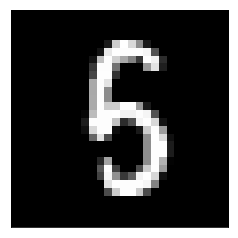

In [32]:
idx = 10
plot_image(xtrain[idx,:])
print (ytrain[idx,:])

## 1. Training the model

All the code for training your model are using the function `train_model` below. 

- You should be able to run your notebook (by clicking 'Cell->Run All') without errors. However, you must save the trained model in the file `model.npz`. This file will be loaded to make predictions in section 2 and assess the performance of the model in section 3.

- It is strongly discouraged to use a full covariance for each of the components of the Gaussian mixture, as the number of parameters grows quadratically on the dimensionality of the data and you will be unable to fit the file size cap in your submission (besides running into various numerical issues). 

In [ ]:
def train_model(xtrain, ytrain):
    """
    Algorithm:
    Step 1: Use PCA for dimensionality reduction. Name the new training set xtrain_pca.
    Step 2: Fit the data to multiple GMMs, use BIC for model selection.
    Step 3: Predict the latent variables of xtrain_pca with the GMM from previous step.
    Step 4: Append the latent variables to xtrain_pca for model training.
    Step 5: Decode the ytrain data from one-hot format, so it can be used for training QDA.
    Step 6: Fit this dataset to Quadratic Discriminant Analysis, which is a class-conditional classifier models.
    Step 7: Save model.
    End
    """
    
    #Step 1 - PCA Reduction.
    pca = PCA(n_components = 50)
    pca.fit(xtrain)
    xtrain_pca = pca.transform(xtrain)
    

    #Step 2 - GMM with BIC model selection.
    lowest_bic = np.infty
    bic = []
    n_components_range = range(10,120)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type)
            gmm.fit(xtrain_pca)
            bic.append(gmm.bic(xtrain_pca))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    
    #Step 3 and 4 - Append the latent variables to our training set.
    gmm = best_gmm
    z1 = gmm.predict(xtrain_pca)
    z1 = np.matrix(z1)
    xtrain_pca = np.matrix(xtrain_pca)
    xtrain_lat = np.concatenate( (xtrain_pca, np.matrix.transpose(z1)), axis = 1 )            
                
    #Step 5 - Decoding one-hot for ytrain
    ytrain_de = list()
    for i in range( len(ytrain)):
        ytrain_de.append(np.argmax(ytrain[i]))
    
    #Step 6 - Train QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(xtrain_lat, ytrain_de)
    
    #Step 7 - Save Model
    np.savez_compressed(
        'model.npz',
        gmm=gmm,
        pca=pca,
        model=qda
    )

## 2. Predictions

Here we will assume that there is a file `mnist_test.npz` from which we will load the test data. The function `make_predictions` should load the `model.npz` file, which must contain all the data structures necessary for making predictions.


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


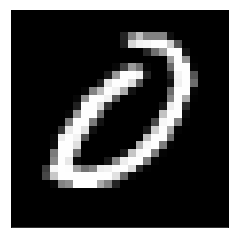

In [74]:
test = np.load('mnist_test.npz')
# test data
xtest = test['xtest']
ytest = test['ytest']
idx = 1000
plot_image(xtest[idx,:])
print (ytest[idx,:])

In [81]:
def make_predictions(xtest):
    """
    @param xtest: (Ntest,D)-array with test data
    @return class_pred: (N,C)-array with predicted classes using one-hot-encoding 
    @return class_logprob: (N,C)-array with  predicted log probability of the classes   
    
    Algorithm:
    Step 1 - Load the model.
    Step 2 - PCA on xtest.
    Step 3 - Predict the latent variables of xtest_pca.
    Step 4 - Append the latent variables to xtest_pca.
    Step 5 - Make prediction, calculate the class the probability.
    Step 6 - One-Hot Encode the results.
    Step 7 - Remove the negative infinity in class_logprob, else predictive_performance function will catch error.
    End
    """
    
    #Step 1 - Load the model.
    qda = np.load('model.npz')['model'].tolist();
    pca = np.load('model.npz')['pca'].tolist();
    gmm = np.load('model.npz')['gmm'].tolist();
    
    #Step 2 - PCA on xtest.
    xtest_pca = pca.transform(xtest)
    
    #Step 3 - Predict the latent variables of xtest_pca.
    z2 = gmm.predict(xtest_pca)
    z2 = np.matrix(z2)
    
    #Step 4 - Append the latent variables to xtest_pca.
    xtest_pca = np.matrix(xtest_pca)
    xtest_lat = np.concatenate( (xtest_pca, np.matrix.transpose(z2)), axis = 1 )
    
    #Step 5 - Make prediction, calculate the class the probability.
    class_pred = qda.predict(xtest_lat)
    class_logprob = qda.predict_log_proba(xtest_lat)
    
    #Step 6 - One-Hot Encode the results.
    lb = LabelBinarizer()
    lb.fit([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    class_pred = lb.transform(class_pred)
    
    #Step 7 - Remove the negative infinity in class_logprob, else predictive_performance function will catch error.
    for i in range( len( class_logprob)):
        for j in range( len(class_logprob[i])):
            if class_logprob[i][j] == -np.infty:
                class_logprob[i][j] = np.nan
                
    return class_pred, class_logprob

## 3. Performance 
This section tests the generalisation performance of the code. Used to evaluate the performance of the algorithm on a new test test. 

In [82]:
def predictive_performance(xdata, ydata, class_pred, class_logprob):
    """
    @param xdata:  (N,D)-array of features 
    @param ydata:  (N,C)-array of one-hot-encoded true classes
    @class_pred: (N,C)-array of one-hot-encoded predicted classes
    @class_logprob: (N,C)-array of predicted class log probabilities 
    """
    correct = np.zeros(xdata.shape[0])
    ltest = np.zeros(xdata.shape[0])
    for i, x in enumerate(xdata):
        correct[i] = np.all(ydata[i, :] == class_pred[i,:])
        ltest[i] = class_logprob[i, np.argmax(ydata[i,:])]
    accuracy = correct.mean()
    loglike = np.nanmean(ltest)
    return accuracy, loglike

In [83]:
class_pred, class_logprob = make_predictions(xtest)
accuracy, loglike = predictive_performance(xtest, ytest, class_pred, class_logprob)

In [84]:
print('Average test accuracy=' + str(accuracy))
print('Average test likelihood=' + str(loglike))

Average test accuracy=0.958535353535
Average test likelihood=-1.17423137112
